In [1]:
# Get the output of Q/K for 4k and 64K before rope and after rope
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.models.llama.modeling_llama import apply_rotary_pos_emb
from types import MethodType
import json


model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype="auto")

with open("/home/azzhang/streaming-llm/output/wikitext2_prompts_llama3.json", "r", encoding="utf-8") as f:
    prompts = json.load(f)

target_length_4k = "1k"

prompt_4k = prompts[target_length_4k]
inputs_4k = tokenizer(prompt_4k, return_tensors="pt").to(model.device)
seq_len_4 = inputs_4k["input_ids"].shape[1]

cache_4k = {}
rope_para = {}
target_layers = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]

def make_patched_forward(layer_idx):
    def patched_forward(self, hidden_states, position_embeddings=None, *args, **kwargs):
        q = self.q_proj(hidden_states)
        k = self.k_proj(hidden_states)
        v = self.v_proj(hidden_states)

        bsz, seqlen, dim = q.shape
        head_dim = self.head_dim
        num_heads_q = self.config.num_attention_heads
        num_heads_kv = self.config.num_key_value_heads

        q = q.view(bsz, seqlen, num_heads_q, head_dim).transpose(1, 2)
        k = k.view(bsz, seqlen, num_heads_kv, head_dim).transpose(1, 2)

        cos, sin = position_embeddings

        rope_para[layer_idx] = {
            "cos": cos.detach().cpu(),
            "sin": sin.detach().cpu(),
            }

        q_rope, k_rope = apply_rotary_pos_emb(q, k, cos, sin)

        
        cache_4k[layer_idx] = {
                "q_raw": q.detach().cpu(),
                "k_raw": k.detach().cpu(),
                "q_rope": q_rope.detach().cpu(),
                "k_rope": k_rope.detach().cpu(),
            }

        return self._orig_forward(hidden_states, position_embeddings, *args, **kwargs)
    
    return patched_forward

for layer_idx in target_layers:
    attn_layer = model.model.layers[layer_idx].self_attn
    attn_layer._orig_forward = attn_layer.forward  
    attn_layer.forward = MethodType(make_patched_forward(layer_idx), attn_layer)


with torch.no_grad():
    outputs = model(**inputs_4k)


/home/azzhang/miniforge3/envs/fms-mo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/azzhang/miniforge3/envs/fms-mo/lib/python3.10/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


In [ ]:
# target_layer = 0
QK_alllayer_before_list = []
QK_alllayer_after_list = []
for target_layer in target_layers:
    K_before_layer, K_after_layer = cache_4k[target_layer]["k_raw"].squeeze(0).float(), cache_4k[target_layer]["k_rope"].squeeze(0).float()
    Q_before_layer, Q_after_layer = cache_4k[target_layer]["q_raw"].squeeze(0).float(), cache_4k[target_layer]["q_rope"].squeeze(0).float()
    QK_before_list = []
    QK_after_list = []
    for target_head in range(8):
        for j in range(4):
            QK_prod_before = Q_before_layer[4*target_head+j] @ K_before_layer[target_head].T
            Max_QK_prod_before = QK_prod_before.max(dim=1).values
            QK_before_list.append(Max_QK_prod_before.mean())
            del QK_prod_before

            QK_prod_after = Q_after_layer[4*target_head+j] @ K_after_layer[target_head].T
            Max_QK_prod_after = QK_prod_after.max(dim=1).values
            QK_after_list.append(Max_QK_prod_after.mean())
            del QK_prod_after
    QK_alllayer_before_list.append(sum(QK_before_list)/len(QK_before_list))
    QK_alllayer_after_list.append(sum(QK_after_list)/len(QK_after_list))

print(sum(QK_alllayer_before_list)/len(QK_alllayer_before_list))
print(sum(QK_alllayer_after_list)/len(QK_alllayer_after_list))
# before 1k: 28.4329 2k:28.7480 4k: 29.5897 8k: 30.0955 16k: 32.5414 32k: 34.5213 64k: 35.5273
# after 1k: 28.7279 2k:33.0219 4k: 44.4354 8k: 62.4520 16k: 103.1137 32k: 144.4112 64k: 183.6317


tensor(28.4329)
tensor(28.7279)


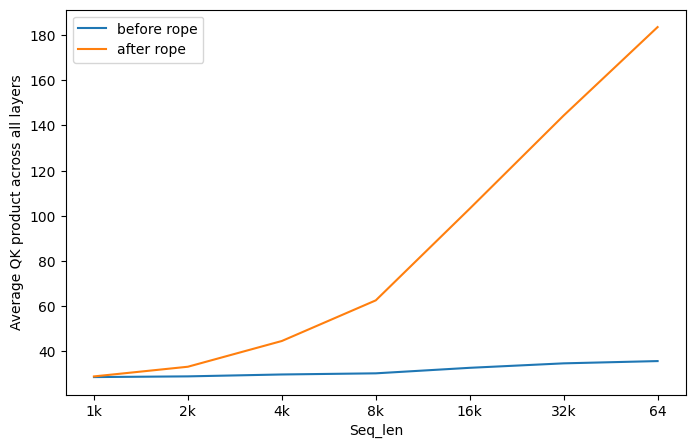

In [4]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 5))
x = [1,2,3,4,5,6,7]
# difference = [(270.3109-159.3434), (297.0381-161.3083), (340.3704-165.2157), (385.6309-168.2895),
#               (513.4606-157.7077), (623.1927-139.5949), (655.7042-101.9491)]
before = [28.4329, 28.7480, 29.5897, 30.0955, 32.5414, 34.5213, 35.5273]
after = [28.7279, 33.0219, 44.4354, 62.4520, 103.1137, 144.4112, 183.6317]
target_length = ['1k','2k','4k', '8k', '16k', '32k', '64']
plt.plot(x, before, label="before rope")
plt.plot(x, after, label="after rope")
# plt.plot(target_layers, ratio_after_rope_all_layer, label="after rope")
# plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
# plt.xticks(target_length)
plt.xticks(ticks=x, labels=target_length)
plt.xlabel("Seq_len")
plt.ylabel("Average QK product across all layers")
# plt.title("Ratio Across Layers with 4k tokens")
plt.legend()
plt.show()